In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
from hyperspherical import cartesian2spherical, spherical2cartesian
%matplotlib widget
from sklearn.utils import shuffle
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data(persons):
    train_data = np.array([])
    test_data = np.array([])
    max_elements = [-100, -100, -100]
    
    for person in persons:
        trajectories = f'./Data/pouring_training_data_S{person}.hdf5'
        reference = f'./Data/pouring_training_referenceObject_positions_S{person}.hdf5'

        training_data_file = h5py.File(trajectories, 'r')
        reference_object_file = h5py.File(reference, 'r')

        reference_object_location = np.squeeze(np.array(reference_object_file['position_m']))

        feature_matrices = np.squeeze(np.array(training_data_file['feature_matrices']))
        labels = training_data_file['labels']

        labels = [label.decode('utf-8') for label in labels]

        hand_loaction = [feature_matrices[i, :, 0:3] for i in range(len(labels))] 
        hand_loaction1 = np.concatenate(hand_loaction)

        max_hand_loaction = np.max(np.abs(hand_loaction1), axis = 0)
        max_object_location = np.max(np.abs(reference_object_location), axis = 0)

        max_location_elements = np.maximum(max_hand_loaction, max_object_location)

        for i in range(len(max_elements)):
            if max_elements[i] < max_location_elements[i]:
                max_elements[i] = max_location_elements[i]

        normalized_df = pd.DataFrame({
            'hand_location': [hand_loaction[i] for i in range(len(labels))],
            'hand_quaternion': [feature_matrices[i, :, 9:13] / 2*np.pi for i in range(len(labels))],
            'wrist_angles': [feature_matrices[i, :, 21:24] / 2*np.pi for i in range(len(labels))],
            'elbow_angles': [feature_matrices[i, :, 24:27] / 2*np.pi for i in range(len(labels))],
            'shoulder_angles': [feature_matrices[i, :, 27:30] / 2*np.pi for i in range(len(labels))],
            'object_location': [reference_object_location[i] for i in range(len(labels))],
        })

        values = normalized_df.values
        if len(train_data) == 0: 
            train_data = values
        else:
            train_data = np.concatenate([train_data, values], axis=0)

    return train_data, max_elements

In [3]:
class CustomeDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.sigmoid = nn.Sigmoid()

    def __len__(self):
        return len(self.data)

    def get_sample(self):
        random_numbers = np.random.uniform(-2, 2, 100)
        return 2 * (self.sigmoid(torch.tensor(random_numbers, dtype=torch.float32)**3) - 0.5)

    def distance_to_object(self, object_location, hand_location):
        return np.sqrt(np.sum((hand_location - object_location)**2))

    def __getitem__(self, index):
        d = self.data[index]
        temp = np.concatenate((d[0], d[1], d[2], d[3], d[4]), axis = 1) 
        first_step = temp[0] 
        object_location = d[-1]
        spherical = cartesian2spherical(first_step[0:3]) 
        object_spherical = cartesian2spherical(object_location)
        distance_to_object = torch.tensor([self.distance_to_object(object_location, temp[i, 0:3]) for i in range(len(temp))], dtype=torch.float32).unsqueeze(dim = 1)
        positions = self.get_sample().unsqueeze(dim = 1)

        x = np.concatenate((first_step, object_spherical, object_location, spherical), axis = 0)
        x = torch.tensor(np.tile(x, (100, 1)), dtype=torch.float32)
        x = torch.cat((x, positions, distance_to_object), dim = 1)[0:len(x) - 1]

        y = torch.tensor(temp[1:, 0:16], dtype=torch.float32)
        return x, y, positions, torch.tensor(object_location, dtype=torch.float32), distance_to_object


In [4]:
class pytorch_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.LOCATION_DIM = 3
        
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, num_layers=1, bias=True, batch_first=True, dropout=0.0, bidirectional=False, device=None, dtype=None)

        self.fc1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x, h0, h_plus = False, residual = False):
        h_n, _ = self.gru(x, h0)
        if h_plus and residual:
            h_shift = torch.cat((h0.squeeze(dim = 0).unsqueeze(dim = 1), h_n[:, 0:-1]), axis = 1)
            output = self.fc1(h_shift + h_n)
            output[:, :, 0:3] = output[:, :, 0:3] + x[:, :, 0:3]
            return output, h_n
        
        if h_plus and not residual:
            h_shift = torch.cat((h0.squeeze(dim = 0).unsqueeze(dim = 1), h_n[:, 0:-1]), axis = 1)
            output = self.fc1(h_shift + h_n)
            return output, h_n

        if not h_plus and residual:
            output = self.fc1(h_n)
            output[:, :, 0:3] = output[:, :, 0:3] + x[:, :, 0:3]
            return output, h_n
        
        if not h_plus and not residual:
            output = self.fc1(h_n)
            return output, h_n

In [5]:
persons = ['00', '11', '10']
data, max_loc_elements = get_data(persons)

In [6]:
for i in range(len(data)):
    data[i][0] = data[i][0] / max_loc_elements
    data[i][-1] = data[i][-1] / max_loc_elements
index = int(len(data) * 0.7)
data = shuffle(data) 
train_data = data[0:index]
test_data = data[index:]
dataset_train = CustomeDataset(train_data)
dataset_test = CustomeDataset(test_data)

In [7]:
HIDDEN_DIM = 100
INPUT_DIM = 27
OUTPUT_DIM = 16 
BATCH_SIZE = 64
EPOCHS = 300

In [8]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, x, y):
        x = x.view(len(x) * x.shape[1], x.shape[-1])
        y = y.view(len(y) * y.shape[1], y.shape[-1])
        mse = self.mse_loss(x, y)
        cosines = torch.cos(2 * np.pi * (x[:, 3:16] - y[:, 3:16])) 
        cosines = cosines / torch.max(cosines)
        cosine_component = 1 - torch.mean(cosines)

        loss = mse #+ cosine_component
        return loss

In [304]:
def train(model, h_plus = False, residual = False):
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    criterion = CustomLoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        dataloader = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle=True)
        
        for x, y, _, _, _ in dataloader:
            optimizer.zero_grad()
            h = torch.zeros(1, len(x), HIDDEN_DIM)
            output, _ = model(x = x, h0 = h, h_plus = h_plus, residual = residual)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        t_loss = total_loss/len(dataloader)
        scheduler.step(t_loss)
        print(f'Epoch {epoch+1}, Loss: {t_loss}')

In [305]:
def test_model(model, dataset, data, h_plus = False, residual = False):   
    paths = [[] for i in range(len(dataset))]
    results = [[] for i in range(len(dataset))]
    total_time = 99
    model.eval()

    with torch.no_grad():
        count = 0
        dataloader = DataLoader(dataset, batch_size = 128, shuffle = False)
        for x, y, s, object_location, d in dataloader:
            model_input = x[:, 0].unsqueeze(dim=1)

            for i in range(len(dataset)):
                    paths[i].append(model_input[i][0][0:3])
                    results[i].append(np.array(model_input[i][0][0:16]))

            h = torch.zeros(1, len(x), HIDDEN_DIM)
            for t in range(total_time):
                output, h = model(x = model_input, h0 = h, h_plus = h_plus, residual = residual)
                h = h.squeeze(dim = 1).unsqueeze(dim = 0)
                model_input[:, :, -1] = x[:, t, -1].unsqueeze(dim = 1)
                model_input[:, :, -2] = x[:, t, -2].unsqueeze(dim = 1)

                for i in range(len(dataset)):
                    paths[i].append(output[i, 0, 0:3])
                    results[i].append(np.array(output[i, 0]))  

    return paths, results

In [306]:
def save_resutls(results, object_locations):

    results_data = pd.DataFrame({
                'hand_location': [np.multiply(results[i, :, 0:3], max_loc_elements) for i in range(len(results))],
                'hand_quaternion': [results[i, :, 3:7] * 2 * np.pi for i in range(len(results))],
                'wrist_angles': [results[i, :, 7:10] * 2 * np.pi for i in range(len(results))],
                'elbow_angles': [results[i, :, 10:13] * 2 * np.pi for i in range(len(results))],
                'shoulder_angles': [results[i, :, 13:16] * 2 * np.pi for i in range(len(results))],
    })

    object_df = pd.DataFrame({'object_location': [np.multiply(np.array(object_locations[i]), max_loc_elements) for i in range(len(results))]})
    
    return results_data, object_df

In [307]:
def plot_models(model_paths, data, samples):
    fig = plt.figure(figsize=(18, 8))
    colores = ['black, perple']
    c = 1
    for i in range(4):
        t = samples[i]
        x1 = [location[0]*max_loc_elements[0] for location in data[t][0]]
        y1 = [location[1]*max_loc_elements[1] for location in data[t][0]]
        z1 = [location[2]*max_loc_elements[2] for location in data[t][0]]
        object_location = data[t][-1]

        for paths in model_paths:
            x = [location[0].item()*max_loc_elements[0] for location in paths[t]]
            y = [location[1].item()*max_loc_elements[1] for location in paths[t]]
            z = [location[2].item()*max_loc_elements[2] for location in paths[t]]
            
            ax = fig.add_subplot(4, 4, c, projection='3d')
            c += 1
            ax.scatter3D(x, y, z, color = "blue", s=10)
            ax.scatter3D(x1, y1, z1, color = "red", s=10)
            
            ax.scatter3D(object_location[0]*max_loc_elements[0], object_location[1]*max_loc_elements[1], object_location[2]*max_loc_elements[2], color="red")
            ax.scatter3D(x[0], y[0], z[0], color="orange", s=100)
            ax.scatter3D(x[-1], y[-1], z[-1], color="green", s=100)
            
            ax.set_xlabel('X Label') 
            ax.set_xlabel('Z Label')
            ax.set_ylabel('Y Label')

    plt.tight_layout()
    plt.show()

In [308]:
model1 = pytorch_GRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

train(model1, h_plus = False, residual = False)

Epoch 1, Loss: 0.9096198678016663
Epoch 2, Loss: 0.7390611171722412
Epoch 3, Loss: 0.5867150723934174
Epoch 4, Loss: 0.4601704478263855
Epoch 5, Loss: 0.3484487235546112
Epoch 6, Loss: 0.26198457181453705
Epoch 7, Loss: 0.20420289039611816
Epoch 8, Loss: 0.17096327990293503
Epoch 9, Loss: 0.15295451879501343
Epoch 10, Loss: 0.1499328538775444
Epoch 11, Loss: 0.15442415326833725
Epoch 12, Loss: 0.1535797417163849
Epoch 13, Loss: 0.1495291292667389
Epoch 14, Loss: 0.14155466109514236
Epoch 15, Loss: 0.1342993602156639
Epoch 16, Loss: 0.12592270225286484
Epoch 17, Loss: 0.12024327367544174
Epoch 18, Loss: 0.11919160187244415
Epoch 19, Loss: 0.11476211249828339
Epoch 20, Loss: 0.11500659584999084
Epoch 21, Loss: 0.1138303242623806
Epoch 22, Loss: 0.11093476042151451
Epoch 23, Loss: 0.11178185790777206
Epoch 24, Loss: 0.10795464739203453
Epoch 25, Loss: 0.10685259848833084
Epoch 26, Loss: 0.1025136262178421
Epoch 27, Loss: 0.10196718946099281
Epoch 28, Loss: 0.10090065374970436
Epoch 29, Lo

In [309]:
model2 = pytorch_GRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

train(model2, h_plus = True, residual = False)

Epoch 1, Loss: 0.7581566572189331
Epoch 2, Loss: 0.5071894377470016
Epoch 3, Loss: 0.33567169308662415
Epoch 4, Loss: 0.22725006937980652
Epoch 5, Loss: 0.17241550981998444
Epoch 6, Loss: 0.15967592597007751
Epoch 7, Loss: 0.16557160764932632
Epoch 8, Loss: 0.1688355952501297
Epoch 9, Loss: 0.16057715564966202
Epoch 10, Loss: 0.14218875020742416
Epoch 11, Loss: 0.12606149911880493
Epoch 12, Loss: 0.11882532015442848
Epoch 13, Loss: 0.11439066752791405
Epoch 14, Loss: 0.11500298231840134
Epoch 15, Loss: 0.11705231294035912
Epoch 16, Loss: 0.11678269878029823
Epoch 17, Loss: 0.11350646615028381
Epoch 18, Loss: 0.11064958199858665
Epoch 19, Loss: 0.10754051804542542
Epoch 20, Loss: 0.10368619486689568
Epoch 21, Loss: 0.10317010059952736
Epoch 22, Loss: 0.10055717080831528
Epoch 23, Loss: 0.09929149225354195
Epoch 24, Loss: 0.0976751558482647
Epoch 25, Loss: 0.09796599298715591
Epoch 26, Loss: 0.0959220826625824
Epoch 27, Loss: 0.09416215494275093
Epoch 28, Loss: 0.09192313626408577
Epoch 

In [310]:
model3 = pytorch_GRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

train(model3, h_plus = False, residual = True)

Epoch 1, Loss: 0.9571691155433655
Epoch 2, Loss: 0.7916680872440338
Epoch 3, Loss: 0.650475949048996
Epoch 4, Loss: 0.5195355117321014
Epoch 5, Loss: 0.400665745139122
Epoch 6, Loss: 0.29925449192523956
Epoch 7, Loss: 0.21473398059606552
Epoch 8, Loss: 0.16865168511867523
Epoch 9, Loss: 0.15654025226831436
Epoch 10, Loss: 0.16297612339258194
Epoch 11, Loss: 0.1698061153292656
Epoch 12, Loss: 0.16520372033119202
Epoch 13, Loss: 0.1542975977063179
Epoch 14, Loss: 0.1438027173280716
Epoch 15, Loss: 0.1367371529340744
Epoch 16, Loss: 0.12917420268058777
Epoch 17, Loss: 0.12475143373012543
Epoch 18, Loss: 0.12292295694351196
Epoch 19, Loss: 0.11945067346096039
Epoch 20, Loss: 0.11869800835847855
Epoch 21, Loss: 0.11603716015815735
Epoch 22, Loss: 0.1140088364481926
Epoch 23, Loss: 0.10962679982185364
Epoch 24, Loss: 0.10734283179044724
Epoch 25, Loss: 0.10494175925850868
Epoch 26, Loss: 0.10320651903748512
Epoch 27, Loss: 0.10092106088995934
Epoch 28, Loss: 0.10120547562837601
Epoch 29, Los

In [311]:
model4 = pytorch_GRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

train(model4, h_plus = True, residual = True)

Epoch 1, Loss: 0.9040018618106842
Epoch 2, Loss: 0.5885409116744995
Epoch 3, Loss: 0.37773461639881134
Epoch 4, Loss: 0.24105791002511978
Epoch 5, Loss: 0.17984583228826523
Epoch 6, Loss: 0.16759583353996277
Epoch 7, Loss: 0.18096375465393066
Epoch 8, Loss: 0.1801012009382248
Epoch 9, Loss: 0.16566691547632217
Epoch 10, Loss: 0.14563117921352386
Epoch 11, Loss: 0.12648162245750427
Epoch 12, Loss: 0.12045315653085709
Epoch 13, Loss: 0.11439315229654312
Epoch 14, Loss: 0.11350121349096298
Epoch 15, Loss: 0.11670142412185669
Epoch 16, Loss: 0.11537957563996315
Epoch 17, Loss: 0.11297214776277542
Epoch 18, Loss: 0.11175874248147011
Epoch 19, Loss: 0.10680487006902695
Epoch 20, Loss: 0.1021304652094841
Epoch 21, Loss: 0.101143017411232
Epoch 22, Loss: 0.09964857250452042
Epoch 23, Loss: 0.10117295756936073
Epoch 24, Loss: 0.09970605000853539
Epoch 25, Loss: 0.0974847860634327
Epoch 26, Loss: 0.09676779434084892
Epoch 27, Loss: 0.0938270315527916
Epoch 28, Loss: 0.09463704749941826
Epoch 29,

In [312]:
model1_results_test, model1_all_results_test = test_model(model1, dataset_test, test_data, h_plus = False, residual = False)
model2_results_test, model2_all_results_test = test_model(model2, dataset_test, test_data, h_plus = True, residual = False)
model3_results_test, model3_all_results_test = test_model(model3, dataset_test, test_data, h_plus = False, residual = True)
model4_results_test, model4_all_results_test = test_model(model4, dataset_test, test_data, h_plus = True, residual = True)

In [313]:
fout = h5py.File(f'results/referenceObject_positions.hdf5', 'w')
objects = np.zeros((len(test_data), 3))
for i in range(len(test_data)):
    for j in range(3):
        objects[i][j] = test_data[i, -1][j] * max_loc_elements[j]
fout.create_dataset('position_m', data=objects)
fout.close()

In [314]:
def save_to_h5py(modelname, model_results_test):
    fout = h5py.File(f'results/{modelname}_output_data.hdf5', 'w')
    model_results_test[:, :, 0:3] = np.multiply(model_results_test[:, :, 0:3], max_loc_elements)
    fout.create_dataset('feature_matrices', data=np.array(model_results_test))
    fout.close()

In [315]:
save_to_h5py('model1', np.array(model1_all_results_test))
save_to_h5py('model2', np.array(model2_all_results_test))
save_to_h5py('model3', np.array(model3_all_results_test))
save_to_h5py('model4', np.array(model4_all_results_test))

In [321]:
# np.random.seed(42)
test_samples = np.random.randint(0, len(dataset_test), 4)
train_samples = np.random.randint(0, len(dataset_train), 4)

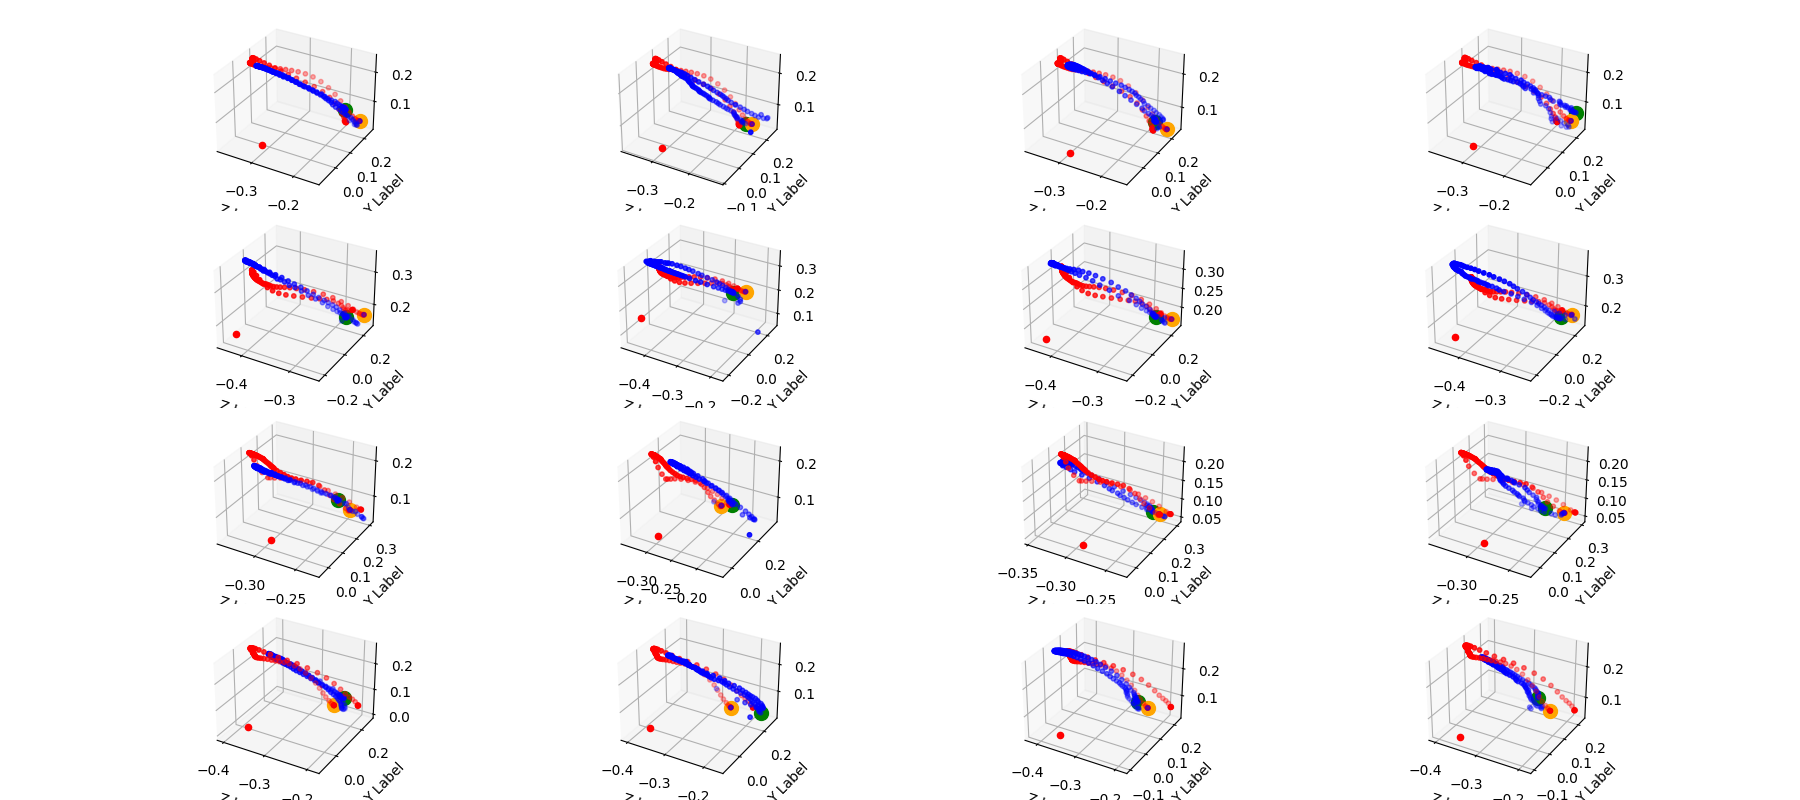

In [322]:
plot_models([model1_results_test, model2_results_test, model3_results_test, model4_results_test], test_data, test_samples)

In [318]:
model1_results_train, model1_all_results_train = test_model(model1, dataset_train, train_data, h_plus = False, residual = False)
model2_results_train, model2_all_results_train = test_model(model2, dataset_train, train_data, h_plus = True, residual = False)
model3_results_train, model3_all_results_train = test_model(model3, dataset_train, train_data, h_plus = False, residual = True)
model4_results_train, model4_all_results_train = test_model(model4, dataset_train, train_data, h_plus = True, residual = True)

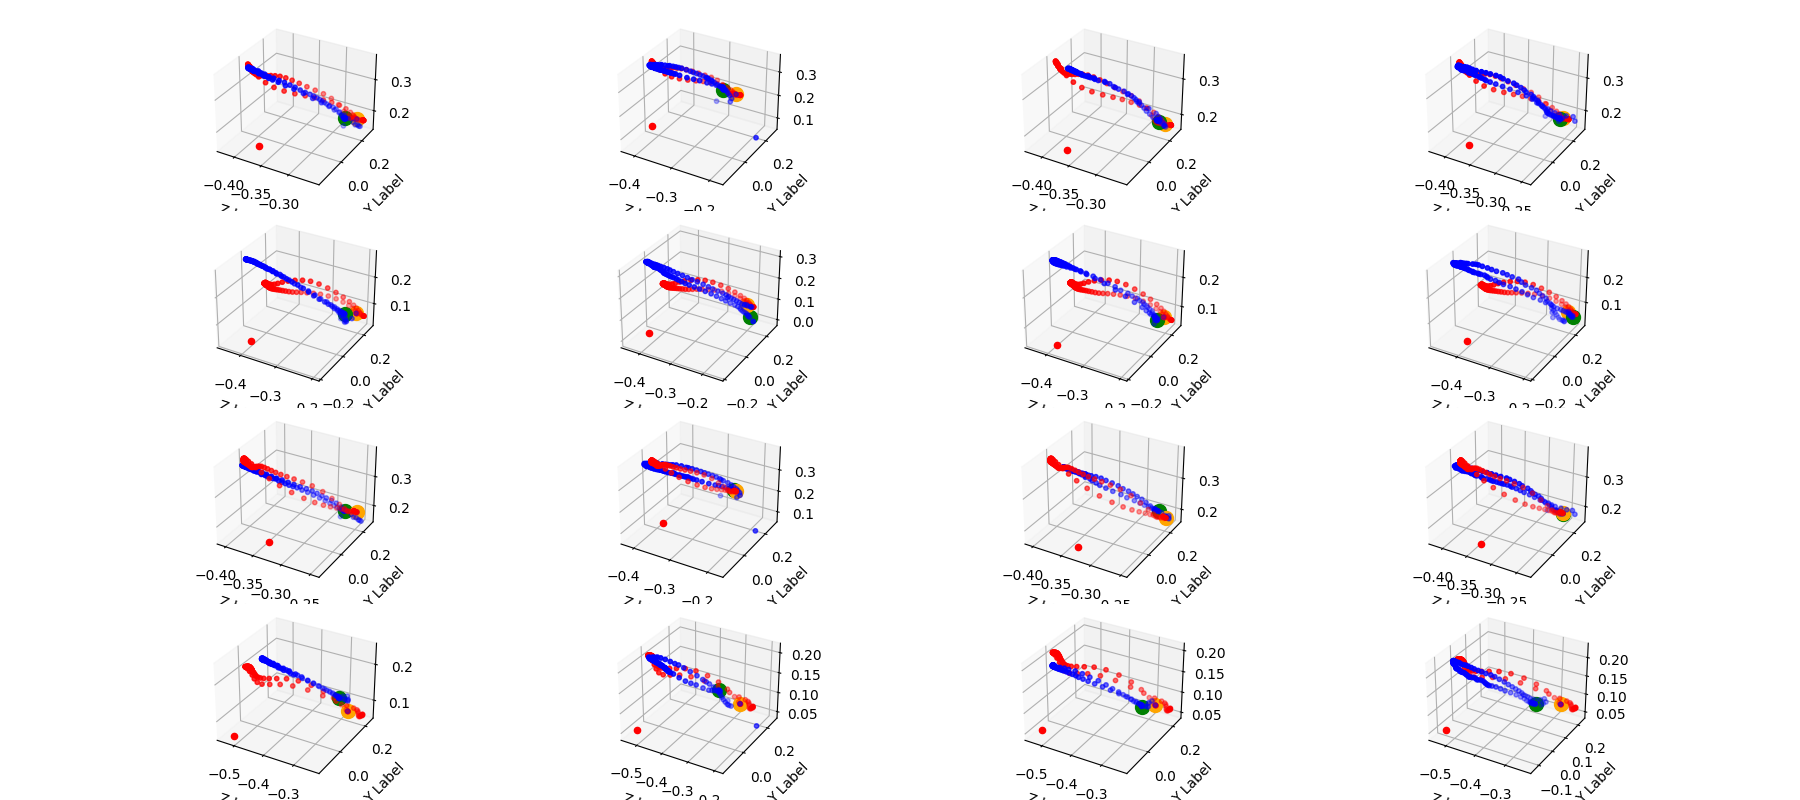

In [319]:
plot_models([model1_results_train, model2_results_train, model3_results_train, model4_results_train], train_data, train_samples)